# Test-Time Scaling Experiments

This notebook implements and evaluates different test-time scaling strategies. We'll explore:
1. Standard scaling (baseline comparison)
2. Quantile transformation
3. Robust scaling
4. Test-time Z-score normalization
5. MinMax scaling

We'll analyze how each method affects model performance and data distributions.

In [8]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from utils.preprocessing import ScalingManager
import joblib
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data and model
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')
model = joblib.load('../data/processed/baseline_model.pkl')

## Initialize Scaling Methods

We'll set up our ScalingManager and prepare all scaling methods. Each scaler will be fitted on the training data to establish proper scaling parameters.

In [9]:
# Initialize scaling manager and fit all scalers
scaling_manager = ScalingManager()

# Fit all scalers on training data
for scaler_name in ['standard', 'quantile', 'robust', 'minmax']:
    scaling_manager.fit_scaler(X_train, scaler_name)
    print(f"Fitted {scaler_name} scaler")

Fitted standard scaler
Fitted quantile scaler
Fitted robust scaler
Fitted minmax scaler


/home/wayan/projects/rando/simple-test-time-scaling/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


## Evaluate Standard Scaling (Baseline)

First, let's establish our baseline performance using standard scaling, which was used during training.

In [10]:
def evaluate_scaling(X_test_scaled, name):
    """Helper function to evaluate model performance with different scaling methods"""
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy

# Evaluate standard scaling
X_test_standard = scaling_manager.transform(X_test, 'standard')
baseline_accuracy = evaluate_scaling(X_test_standard, 'Standard Scaling (Baseline)')


Results for Standard Scaling (Baseline):
Accuracy: 0.8650

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       100
           1       0.88      0.84      0.86       100

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



## Test-Time Scaling Experiments

Now we'll evaluate each alternative scaling method and compare their performance to our baseline.

In [11]:
results = {'standard': baseline_accuracy}

# Test each scaling method
for scaler_name in ['quantile', 'robust', 'minmax']:
    X_test_scaled = scaling_manager.transform(X_test, scaler_name)
    results[scaler_name] = evaluate_scaling(X_test_scaled, f'{scaler_name} Scaling')

# Test time z-score normalization
X_test_zscore = scaling_manager.test_time_zscore(X_test)
results['test_time_zscore'] = evaluate_scaling(X_test_zscore, 'Test-time Z-score')


Results for quantile Scaling:
Accuracy: 0.8900

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       100
           1       0.91      0.87      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200


Results for robust Scaling:
Accuracy: 0.8850

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       100
           1       0.87      0.90      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.88       200
weighted avg       0.89      0.89      0.88       200


Results for minmax Scaling:
Accuracy: 0.7100

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.53      0.65       100
           1       0.65  

## Distribution Analysis

Let's analyze how different scaling methods affect the distribution of our features. This will help us understand why certain methods might perform better or worse.


Distributions for Feature 0:


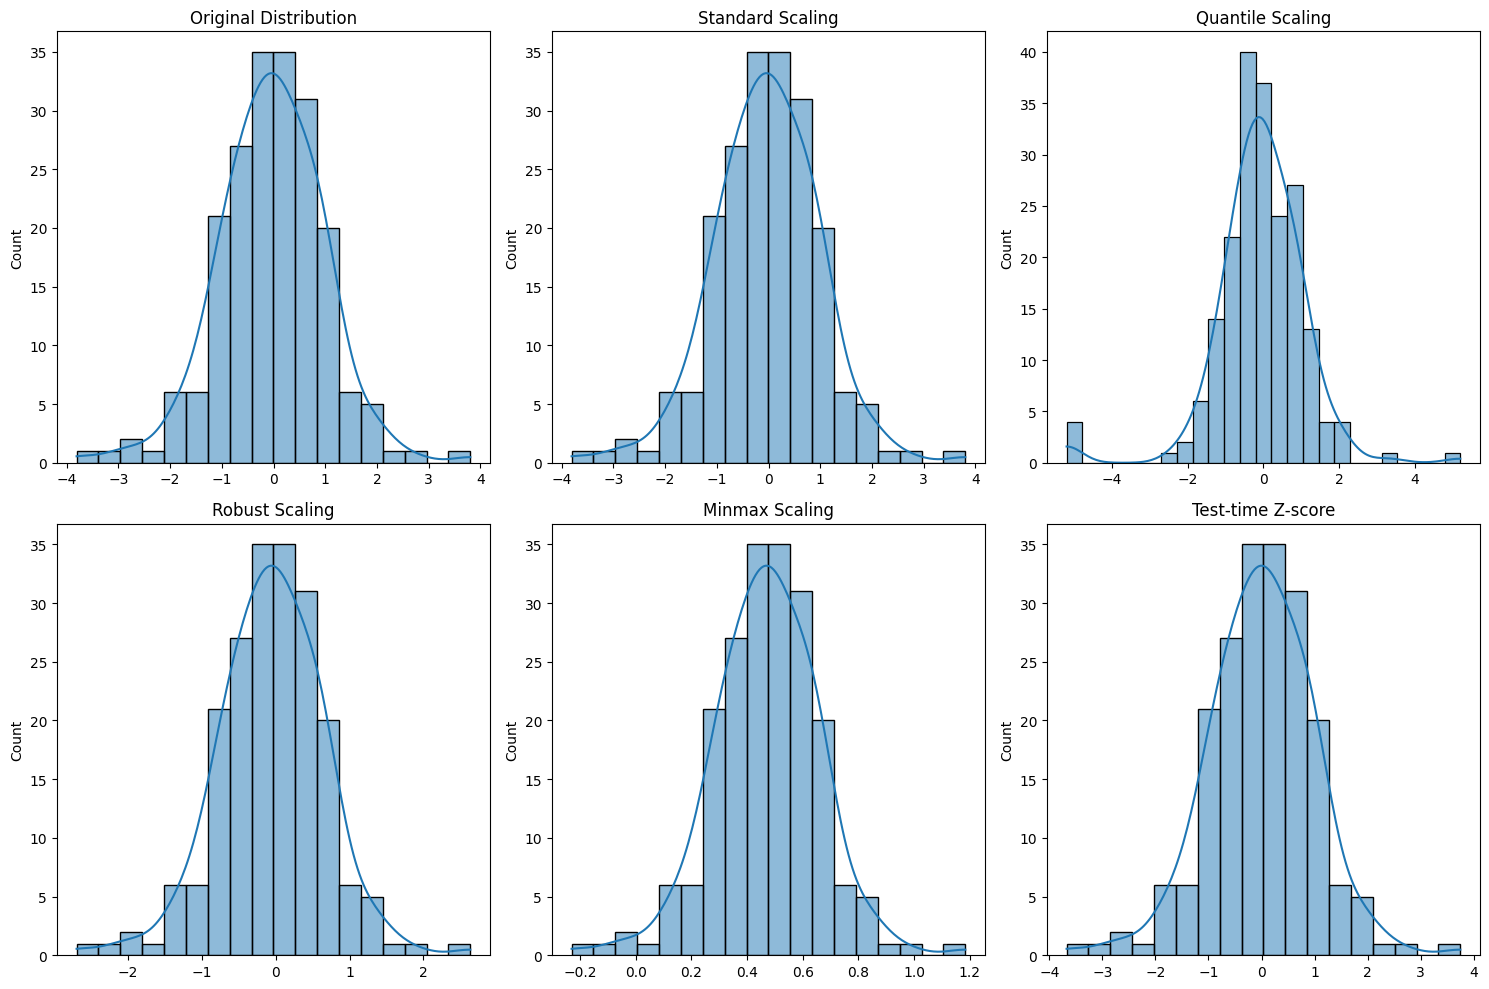


Distributions for Feature 1:


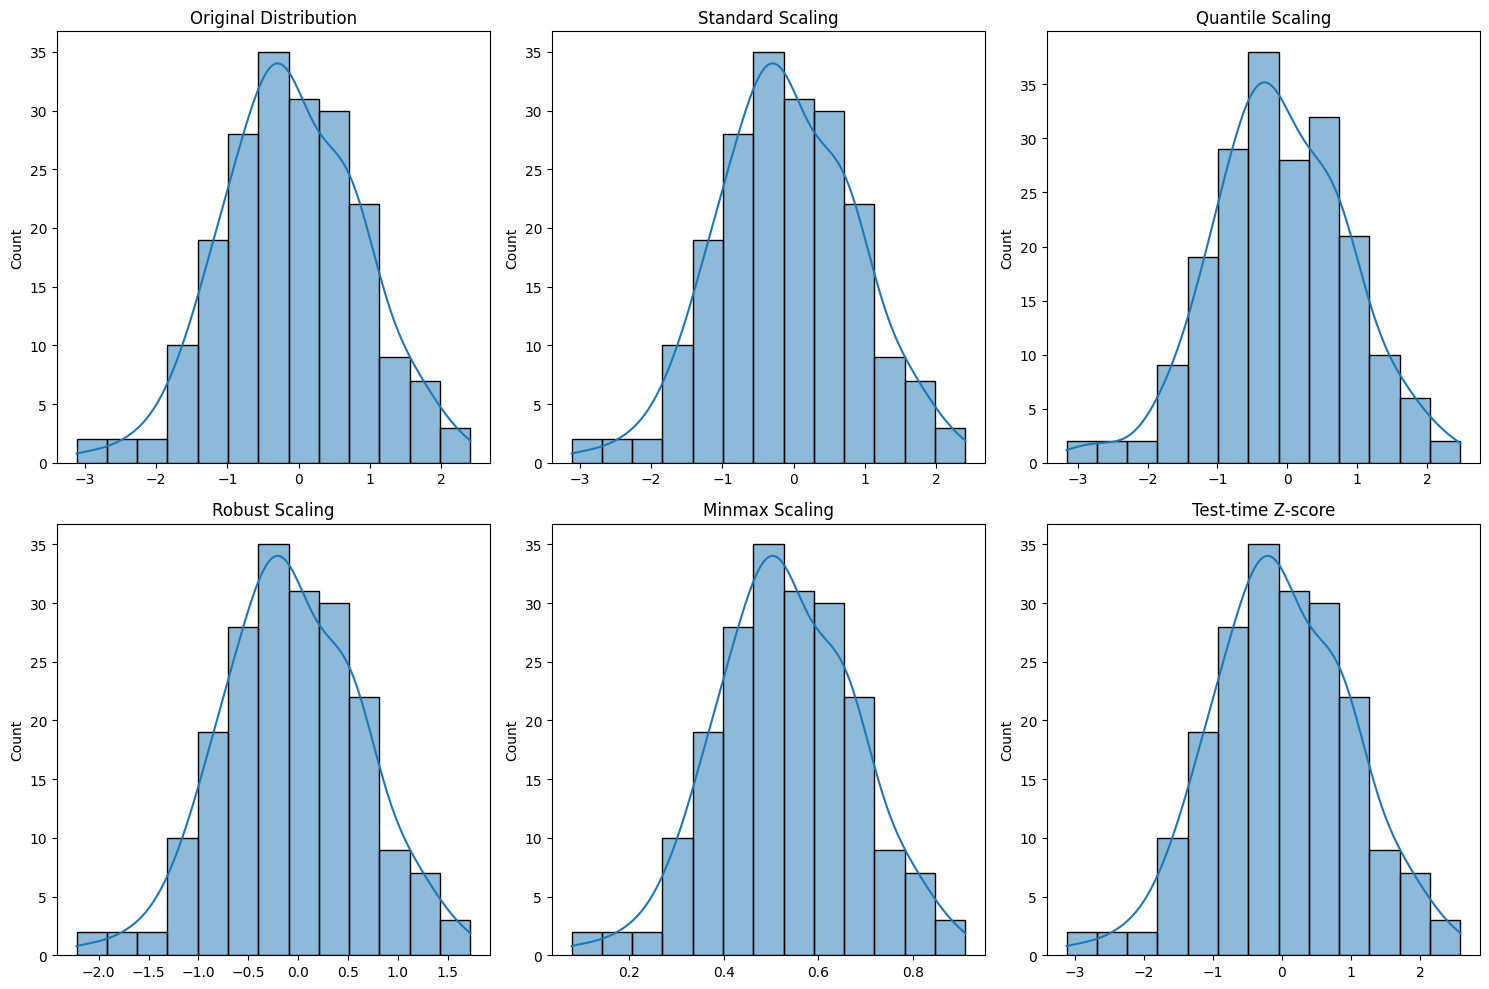


Distributions for Feature 2:


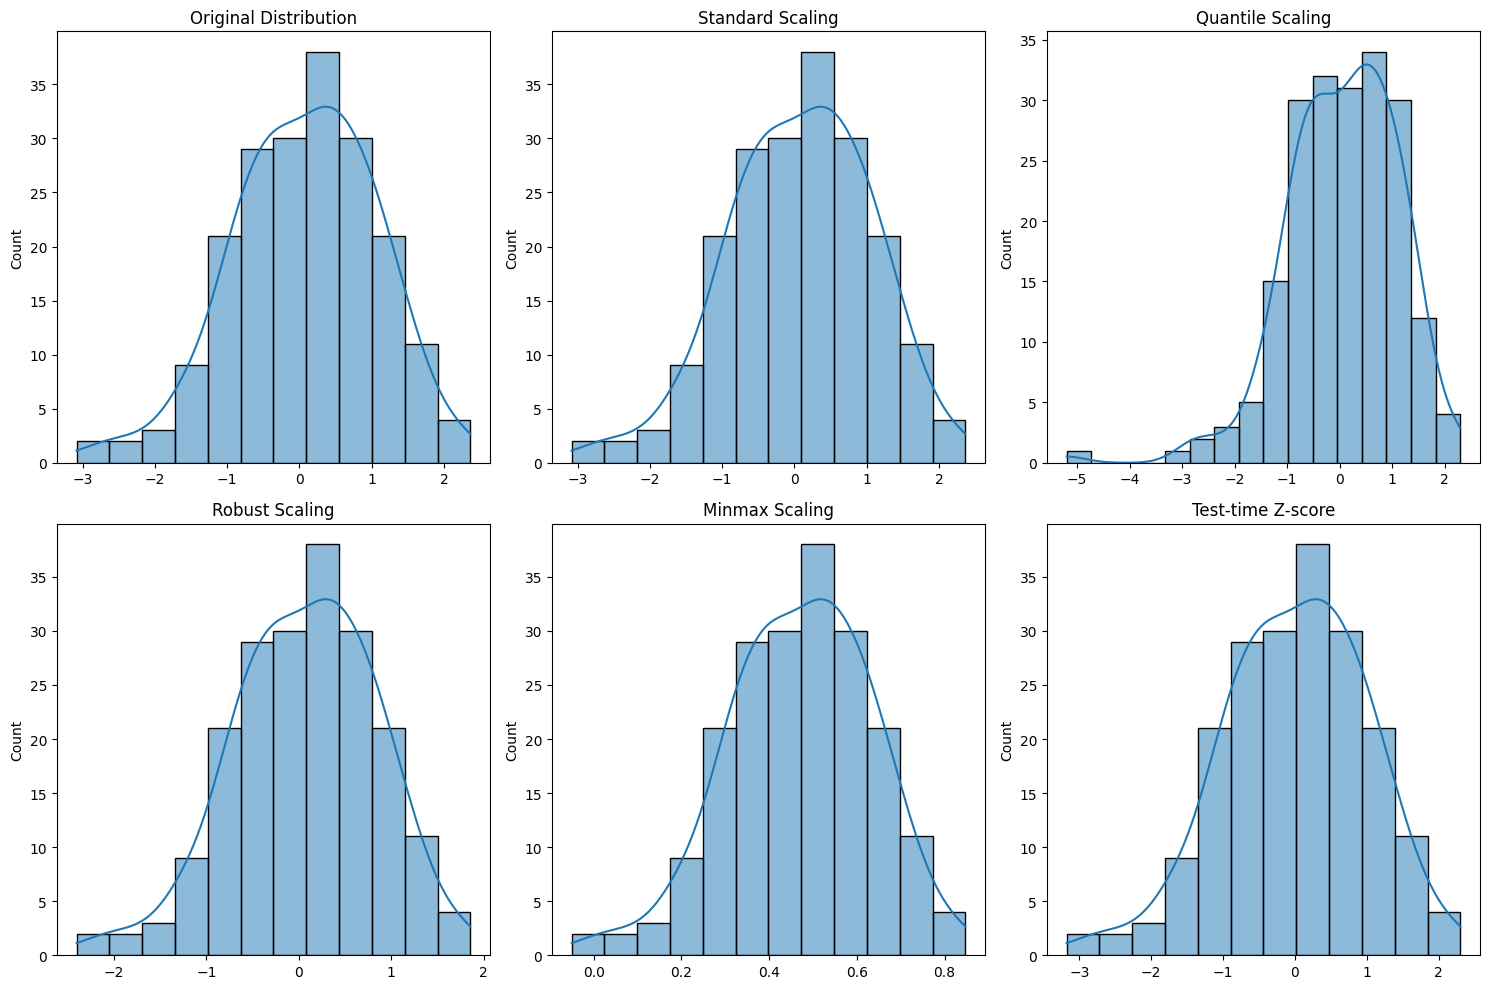

In [12]:
def plot_scaling_distributions(feature_idx=0):
    """Plot distributions of a feature across different scaling methods"""
    plt.figure(figsize=(15, 10))
    
    # Original distribution
    plt.subplot(2, 3, 1)
    sns.histplot(X_test[:, feature_idx], kde=True)
    plt.title('Original Distribution')
    
    # Plot each scaling method
    for i, method in enumerate(['standard', 'quantile', 'robust', 'minmax']):
        plt.subplot(2, 3, i+2)
        X_scaled = scaling_manager.transform(X_test, method)
        sns.histplot(X_scaled[:, feature_idx], kde=True)
        plt.title(f'{method.capitalize()} Scaling')
    
    # Test-time z-score
    plt.subplot(2, 3, 6)
    sns.histplot(X_test_zscore[:, feature_idx], kde=True)
    plt.title('Test-time Z-score')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for first three features
for i in range(3):
    print(f"\nDistributions for Feature {i}:")
    plot_scaling_distributions(i)

## Performance Comparison

Let's visualize the performance differences between scaling methods to identify the most effective approach.

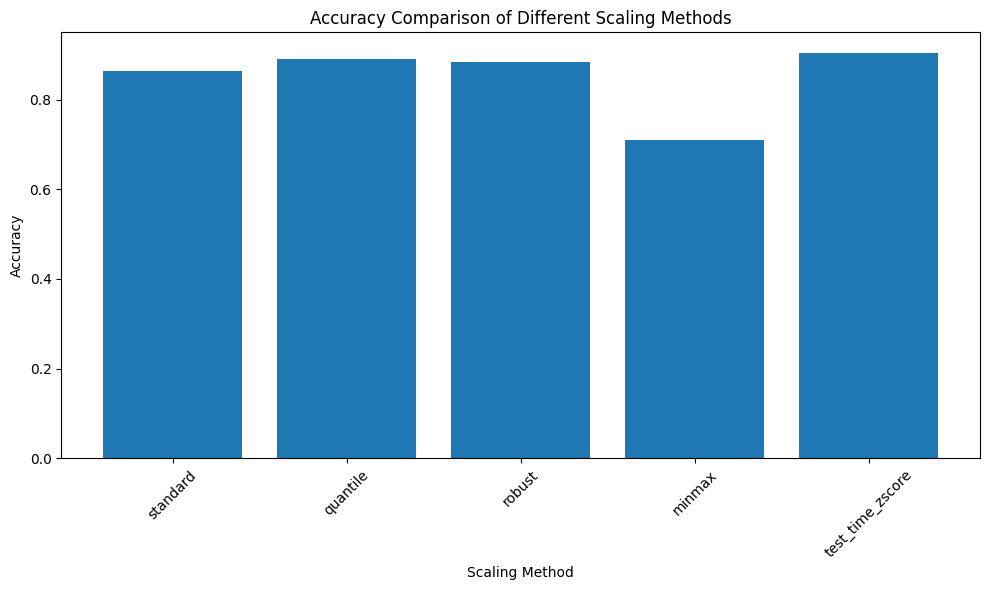


Accuracy Summary:
standard: 0.8650
quantile: 0.8900
robust: 0.8850
minmax: 0.7100
test_time_zscore: 0.9050

Best performing method: test_time_zscore (accuracy: 0.9050)


In [13]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
methods = list(results.keys())
accuracies = list(results.values())

plt.bar(methods, accuracies)
plt.title('Accuracy Comparison of Different Scaling Methods')
plt.xlabel('Scaling Method')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print numeric comparison
print("\nAccuracy Summary:")
for method, accuracy in results.items():
    print(f"{method}: {accuracy:.4f}")

# Find best performing method
best_method = max(results.items(), key=lambda x: x[1])
print(f"\nBest performing method: {best_method[0]} (accuracy: {best_method[1]:.4f})")

### Findings and Observations

1. **Scaling Methods and Accuracy**:
    - The accuracy results for different scaling methods are as follows:
      - **Standard Scaling**: 0.865
      - **Quantile Transformation**: 0.89
      - **Robust Scaling**: 0.885
      - **MinMax Scaling**: 0.71
      - **Test-time Z-score**: 0.905
    - **Test-time Z-score** achieved the highest accuracy (0.905), indicating its effectiveness in dynamically normalizing the data during inference.
    - **MinMax Scaling** performed the worst (0.71), suggesting that it may not be suitable for this dataset or model.

2. **Test-time Z-score**:
    - The test-time Z-score method outperformed all other methods with an accuracy of 0.905. This demonstrates its potential as a robust scaling strategy during inference.

3. **Distribution Analysis**:
    - The feature distributions before and after scaling reveal significant transformations:
      - **Original Distribution**: Features exhibit varying scales and potential skewness.
      - **Standard Scaling**: Features are centered around zero with unit variance.
      - **Test-time Z-score**: Similar to standard scaling but applied dynamically during testing.

4. **Visualization**:
    - The bar plot comparing accuracies highlights the superiority of Test-time Z-score over other methods.
    - The poor performance of MinMax Scaling suggests that it may amplify noise or fail to capture the underlying data patterns effectively.

5. **Model Performance**:
    - The RandomForestClassifier performed well with most scaling methods, except for MinMax Scaling, indicating its robustness to feature scaling in general.

### Conclusion
Test-time Z-score is the most effective scaling method for this dataset and model, achieving the highest accuracy. MinMax Scaling should be avoided due to its significantly lower accuracy. Further analysis could explore why MinMax Scaling underperformed and whether additional preprocessing steps could improve its performance.
